In [2]:
import dataloader2
import numpy as np
import os
len(dataloader2.good_sids)

37

In [11]:
np.random.seed(42)
train_sids = np.random.choice(dataloader2.good_sids, 30)
test_sids = [i for i in dataloader2.good_sids if i not in train_sids]

In [51]:
test_sids

['08db4255286f',
 '1087d7b0ff2e',
 '10f8bc1f7b07',
 '18b61dd5aae8',
 '3452b878e596',
 '349c5562ee2c',
 '55a47ff9dc8a',
 '5acc9d63b5fd',
 '67f5fc60e494',
 '72bbd1ac3edf',
 '7822ee8fe3ec',
 'a9a2f7fac455',
 'c6788e579967',
 'c68260cc9e8f',
 'd150801f3145',
 'd25e479ecbb7']

In [26]:
import importlib
importlib.reload(model1min)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 1, 14, 32)         800       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 4, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 22        
Total params: 2,112
Trainable params: 2,112
Non-trainable params: 0
_________________________________________________________________


<module 'models.model1min' from '/home/014315366/ML-Maniacs/models/model1min.py'>

In [1]:
from models import model1min

2023-11-20 02:34:05.656286: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 14, 32)         800       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 4, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 22        
Total params: 2,112
Trainable params: 2,112
Non-trainable params: 0
_________________________________________________________________


2023-11-20 02:34:07.765247: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-11-20 02:34:07.766435: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-11-20 02:34:07.779475: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: Tesla P100-PCIE-12GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 511.41GiB/s
2023-11-20 02:34:07.779500: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-11-20 02:34:07.782168: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-11-20 02:34:07.782201: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10

In [12]:
# if model1min.is_not_trained():
from tqdm.notebook import tqdm
training_files = [os.path.join("data", "sids", f"{sid}.parquet") for sid in tqdm(train_sids)]
training_XandIndex = [model1min.getXandIndex(sid_file) for sid_file in tqdm(training_files)]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [13]:
import pandas as pd

dfs = (dataloader2.load_sid(sid_f) for sid_f in training_files)
training_y = [(df['activity']=='Sleeping').astype(int) for df in tqdm(dfs, total=len(training_files))]

  0%|          | 0/30 [00:00<?, ?it/s]

In [14]:
training_y = [y.loc[index] for y,(_,index) in zip(training_y, training_XandIndex)]

In [15]:
len(training_XandIndex), len(training_y)

(30, 30)

In [16]:
all([training_XandIndex[i][0].shape[0]==training_y[i].shape[0] for i in range(30)])

True

In [30]:
X = np.concatenate([i[0] for i in training_XandIndex])
X = np.stack([X], axis=-1)
y = np.concatenate(training_y)
X.shape, y.shape

((11393280, 2, 25, 1), (11393280,))

In [31]:
val_size = sum([len(i) for i in training_y[-2:]])
from sklearn.utils import shuffle
x_train, y_train = shuffle(X[:-val_size], y[:-val_size], random_state=42)
x_test, y_test = X[-val_size:], y[-val_size:]

for i in [x_train, y_train, x_test, y_test]:
    print(i.shape)

(10499808, 2, 25, 1)
(10499808,)
(893472, 2, 25, 1)
(893472,)


In [35]:
if model1min.is_not_trained():
    from tensorflow import keras
    model1min.model.compile(
        optimizer='adam',
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy'],
#         jit_compile=True
    )
    cp_callback = keras.callbacks.ModelCheckpoint(
        model1min.checkpoint_file,
        save_weights_only=True,
        verbose=1
    )
    hist = model1min.model.fit(
        x_train,
        y_train,
        epochs=10,
        validation_data=(x_test, y_test),
        callbacks=[cp_callback],
        batch_size=500
    )

Epoch 1/10
21000/21000 [==============================] - 33s 2ms/step - loss: 0.2202 - accuracy: 0.9178 - val_loss: 0.1606 - val_accuracy: 0.9487

Epoch 00001: saving model to model1min/cp.ckpt
Epoch 2/10
21000/21000 [==============================] - 32s 2ms/step - loss: 0.2170 - accuracy: 0.9192 - val_loss: 0.1546 - val_accuracy: 0.9526

Epoch 00002: saving model to model1min/cp.ckpt
Epoch 3/10
21000/21000 [==============================] - 32s 2ms/step - loss: 0.2154 - accuracy: 0.9199 - val_loss: 0.1629 - val_accuracy: 0.9482

Epoch 00003: saving model to model1min/cp.ckpt
Epoch 4/10
21000/21000 [==============================] - 32s 2ms/step - loss: 0.2142 - accuracy: 0.9202 - val_loss: 0.1539 - val_accuracy: 0.9526

Epoch 00004: saving model to model1min/cp.ckpt
Epoch 5/10
21000/21000 [==============================] - 32s 2ms/step - loss: 0.2131 - accuracy: 0.9205 - val_loss: 0.1516 - val_accuracy: 0.9552

Epoch 00005: saving model to model1min/cp.ckpt
Epoch 6/10
21000/21000 [=

In [36]:
history = pd.DataFrame(hist.history)
history

,loss,accuracy,val_loss,val_accuracy
0,0.219126,0.918222,0.160610,0.948695
1,0.216422,0.919396,0.154556,0.952601
2,0.215059,0.919859,0.162911,0.948157
3,0.213728,0.920369,0.153860,0.952633
4,0.212489,0.920822,0.151648,0.955206
5,0.211526,0.921244,0.152647,0.952109
6,0.211160,0.921354,0.152186,0.954104
7,0.210336,0.921695,0.149672,0.955826
8,0.209800,0.921957,0.151635,0.953143
9,0.209377,0.922200,0.148479,0.958195


/home/014315366/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/014315366/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/014315366/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/014315366/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

Text(0, 0.5, 'Loss')

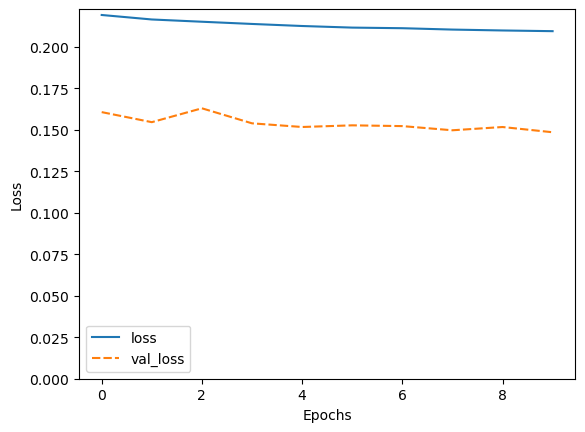

In [40]:
import seaborn as sns

ax = sns.lineplot(data=history.loc[:, ['loss', 'val_loss']])
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

/home/014315366/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/014315366/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/014315366/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/014315366/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

Text(0, 0.5, 'Accuracy')

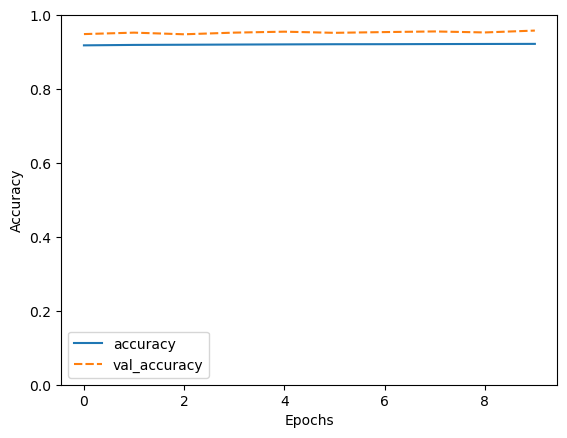

In [43]:
ax = sns.lineplot(data=history.loc[:, ["accuracy", "val_accuracy"]])
ax.set_ylim(0, 1)
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")

In [44]:
sid = test_sids[0]
sid

'08db4255286f'

In [45]:
test_files = [os.path.join("data", "sids", f"{sid}.parquet") for sid in tqdm(test_sids)]
test_XandIndex = [model1min.getXandIndex(sid_file) for sid_file in tqdm(test_files)]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [46]:
a
testing_y = [(df['activity']=='Sleeping').astype(int) for df in tqdm(dfs, total=len(test_files))]

  0%|          | 0/16 [00:00<?, ?it/s]

In [47]:
testing_y = [y.loc[index] for y,(_,index) in zip(testing_y, test_XandIndex)]

In [48]:
len(test_XandIndex), len(testing_y)

(16, 16)

In [58]:
all([test_XandIndex[i][0].shape[0]==testing_y[i].shape[0] for i in range(16)])

True

In [61]:
preds = [model1min.model(np.stack([x], axis=-1)) for (x,_) in tqdm(test_XandIndex)]

  0%|          | 0/16 [00:00<?, ?it/s]

2023-11-20 03:24:21.214834: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 829.46MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


In [66]:
dfs = (dataloader2.load_sid(sid_f) for sid_f in test_files)
tss = [df.loc[index, 'timestamp'] for df, (_,index) in zip(dfs, test_XandIndex)]


  0%|          | 0/881 [00:00<?, ?it/s]

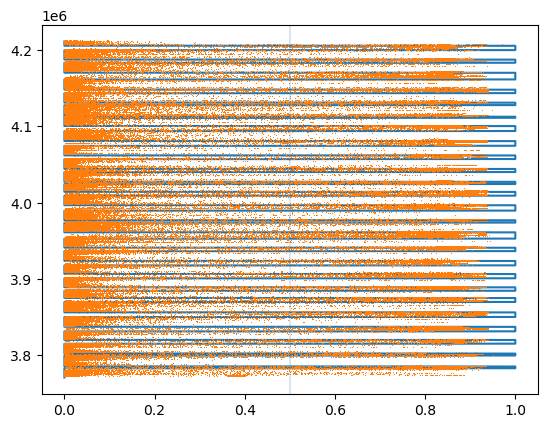

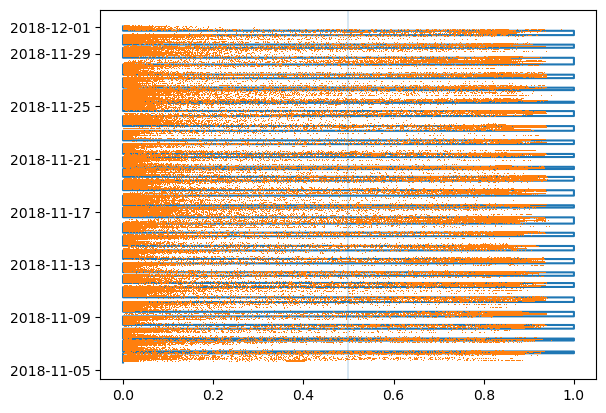

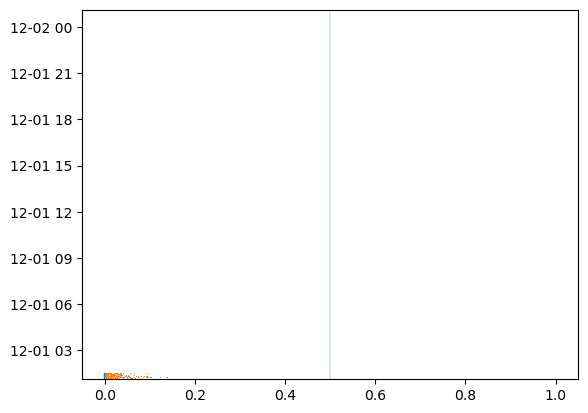

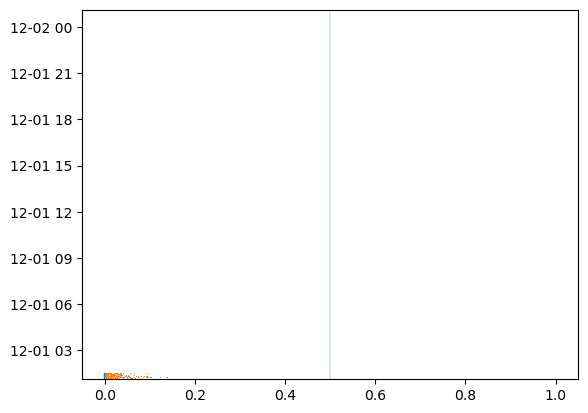

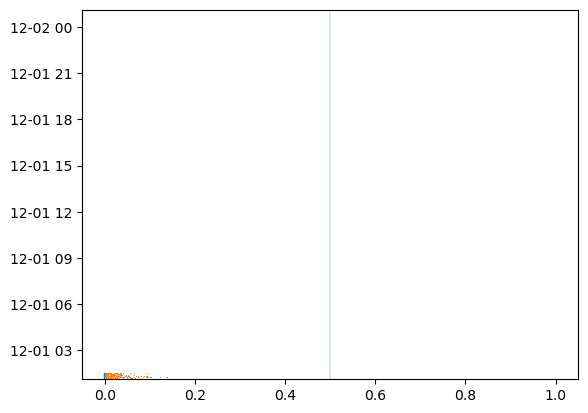

In [70]:
%matplotlib inline
import visual
anime = visual.scrol_predictions(
    preds[0][:,1],
    testing_y[0],
    tss[0],
    pd.Timedelta(1, 'day')
)
anime.save('tmp.mp4')

In [77]:
smooths = [np.convolve(i[:,1], [1./12]*12, 'same') for i in preds]

  0%|          | 0/881 [00:00<?, ?it/s]

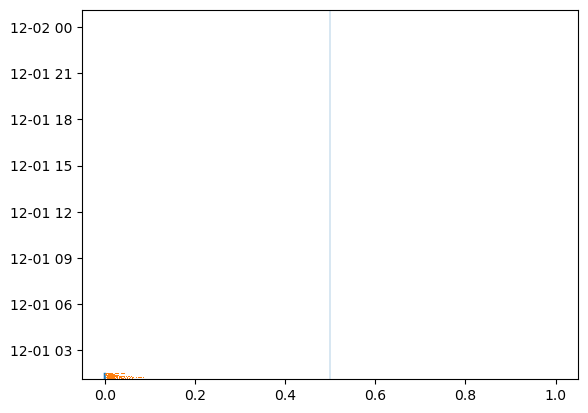

In [78]:
anime = visual.scrol_predictions(
    smooths[0],
    testing_y[0],
    tss[0],
    pd.Timedelta(1, 'day')
)
anime.save('tmp_sm1.mp4')

  0%|          | 0/1101 [00:00<?, ?it/s]

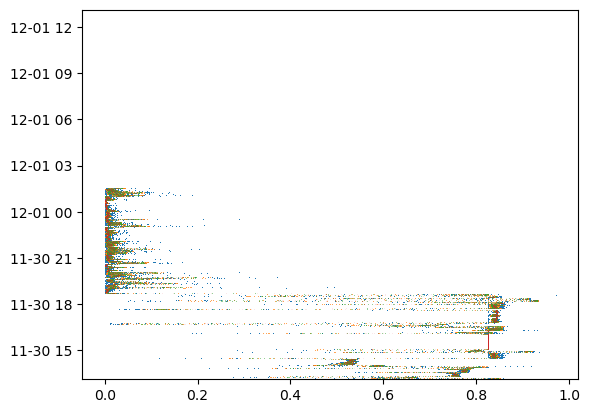

In [85]:
import matplotlib.pyplot as plt
plt.plot(preds[0][:,1], tss[0], ',')
smooths = [np.convolve(i[:,1], [1./12]*12, 'same') for i in preds]
plt.plot(smooths[0], tss[0], ',', alpha=0.7)
smooths = [np.convolve(i, [1./12]*12, 'same') for i in smooths]
plt.plot(smooths[0], tss[0], ',', alpha=0.5)
smooths = [np.convolve(i, [1./12]*12, 'same') for i in smooths]
smooths = [np.convolve(i, [1./12]*12, 'same') for i in smooths]
smooths = [np.convolve(i, [1./12]*12, 'same') for i in smooths]
plt.plot(smooths[0], tss[0], ',', alpha=0.1)
def set_frame(ts):
    plt.ylim(ts-pd.Timedelta(0.5,'day'), ts+pd.Timedelta(0.5,'day'))
    return []
import matplotlib.animation as anim
anime = anim.FuncAnimation(
    plt.gcf(),
    set_frame,
    tqdm([tss[0].iloc[i] for i in range(0, len(tss[0]), 400)]),
    interval=44,
    blit=True
)
anime.save('overlap.mp4')
None
            

[]

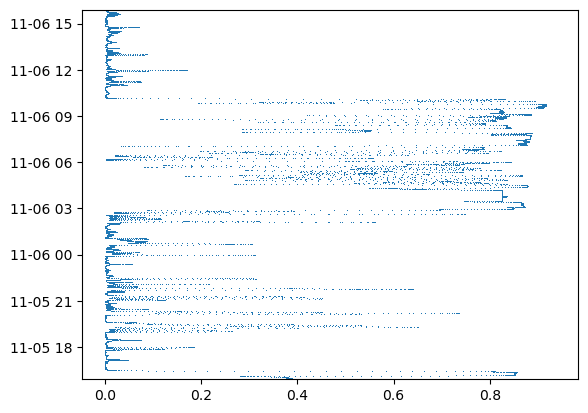

In [91]:
plt.plot(smooths[0], tss[0], ',',)
set_frame(tss[0].iloc[10000])

In [102]:
np.convolve([1,2,3,4], [1,2,3, 4, 5, 6], 'same')

array([ 4, 10, 20, 30, 40, 43])